#  Разворачивание и публикация моделей. Streamlit.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://docs.streamlit.io/get-started
* https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/Create_streamlit_app.ipynb#scrollTo=meJ36PefNftd
* https://www.youtube.com/playlist?list=PLtqF5YXg7GLmCvTswG32NqQypOuYkPRUE
* https://docs.streamlit.io/develop/api-reference/widgets/st.slider
* https://docs.streamlit.io/develop/api-reference/media/st.image
* https://docs.streamlit.io/develop/api-reference/widgets/st.file_uploader
* https://docs.streamlit.io/develop/api-reference/caching-and-state/st.session_state

## Задачи для совместного разбора

In [72]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import subprocess
import sys
import atexit
import time
import os

import warnings

warnings.filterwarnings('ignore')

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
pl.seed_everything(SEED)

OUT_DIR = Path("artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)


Seed set to 42


1\. Обсудите базовые возможности по созданию веб-приложения при помощи `streamlit` на примере построения графика функции $y=x^p, x\in[-x_{min}, x_{max}]$.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте датасет на основе предоставленного файла `synthetic_coffee_health_10000.csv`. 
Для построения модели используйте следующие признаки: 
* возраст
* потребление кофе
* индекс массы тела
* индикатор курение 
* индикатор потребления алкоголя
* профессия. 

Целевая переменная - качество сна. 

Стандартизируйте признаки и закодируйте категориальные переменные и классы целыми числами.

Обучите простую модель нейронной сети на этом датасете, посчитайте отчет о классификации (classification report) для обучающей и тестовой выборок. Сохраните веса модели и все вспомогательные объкты (label encoders, standard scaler и т.д.) на диск.

- [ ] Проверено на семинаре

`Age`
`Coffee_Intake`
`BMI`
`Smoking`
`Alcohol_Consumption`
`Occupation`

`Sleep_Quality`

In [73]:
df = pd.read_csv("synthetic_coffee_health_10000.csv")

cols = ["Age", "Coffee_Intake", "BMI", "Smoking", "Alcohol_Consumption", "Occupation", "Sleep_Quality"]
df = df[cols].copy()

df = df.dropna().reset_index(drop=True)

cat_cols = ["Smoking", "Alcohol_Consumption", "Occupation"]
num_cols = ["Age", "Coffee_Intake", "BMI"]
target_col = "Sleep_Quality"

label_encoders = {}
for c in cat_cols + [target_col]:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

X = df[num_cols + cat_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

joblib.dump(scaler, OUT_DIR / "scaler.joblib")
for name, le in label_encoders.items():
    joblib.dump(le, OUT_DIR / f"label_encoder_{name}.joblib")

In [74]:
BATCH_SIZE = 128

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [75]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        if alpha is not None:
            self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        else:
            self.register_buffer('alpha', None)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction="none")(logits, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        return focal_loss

class SimpleNN(pl.LightningModule):
    def __init__(self, input_dim, num_classes, lr=1e-3, alpha=None):
        super().__init__()
        self.save_hyperparameters()

        # Только один скрытый слой с 16 нейронами. Меньше — только логистическая регрессия.
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, num_classes)
        )
        
        self.loss_fn = FocalLoss(alpha=alpha, gamma=2.0)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [76]:
(unique, counts) = np.unique(y_train, return_counts=True)
num_classes = len(unique)

weights = 1.0 / np.log(counts + 1.01)
weights = weights / weights.sum()


input_dim = X_train.shape[1]

model = SimpleNN(
    input_dim=input_dim,
    num_classes=num_classes,
    lr=5e-4,
    alpha=weights
)

In [77]:
checkpoint_callback = ModelCheckpoint(
    dirpath=OUT_DIR,
    filename="sleep_quality_model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=6, mode="min")

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    logger=False,
    enable_progress_bar=True
)

trainer.fit(model, train_loader, val_loader)
best_model_path = checkpoint_callback.best_model_path

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 212    | train
1 | loss_fn | FocalLoss  | 0      | train
-----------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if best_model_path:
    print(f"Загрузка лучшей модели из: {best_model_path}")
    model = SimpleNN.load_from_checkpoint(best_model_path)
else:
    print("Лучшая модель не найдена, используем модель после последнего шага обучения.")

model.eval()
model.to(device)


def predict_dataset(model, X_np, batch_size=256):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, X_np.shape[0], batch_size):
            batch_np = X_np[i:i+batch_size]
            batch_tensor = torch.from_numpy(batch_np).to(device)
            
            logits = model(batch_tensor)
            p = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(p)
            
    return np.concatenate(preds, axis=0)


y_train_pred = predict_dataset(model, X_train)
y_test_pred = predict_dataset(model, X_test)

le_target = label_encoders[target_col]

print("\n--- Classification report on TRAIN set: ---")
print(classification_report(y_train, y_train_pred, digits=4))

print("\n--- Classification report on TEST set: ---")
print(classification_report(y_test, y_test_pred, digits=4))

Загрузка лучшей модели из: C:\Projects\FU\Course_3\DL\artifacts\sleep_quality_model-epoch=27-val_loss=0.0227-v1.ckpt

--- Classification report on TRAIN set: ---
              precision    recall  f1-score   support

           0     0.1429    0.0009    0.0018      1082
           1     0.2736    0.0177    0.0332      1640
           2     0.5640    0.9820    0.7165      4509
           3     0.1667    0.0078    0.0149       769

    accuracy                         0.5580      8000
   macro avg     0.2868    0.2521    0.1916      8000
weighted avg     0.4093    0.5580    0.4123      8000


--- Classification report on TEST set: ---
              precision    recall  f1-score   support

           0     0.6667    0.0074    0.0147       270
           1     0.3214    0.0220    0.0411       410
           2     0.5677    0.9849    0.7203      1128
           3     0.1667    0.0104    0.0196       192

    accuracy                         0.5620      2000
   macro avg     0.4306    0.2562

In [79]:
import json
model_save_path = OUT_DIR / "sleep_quality_model_state_dict.pt"
torch.save(model.state_dict(), model_save_path)


meta = {
    "feature_columns": cols,
    "target_column": target_col,
    
    # Пути к файлам предобработки
    "label_encoders": {k: str(OUT_DIR / f"label_encoder_{k}.joblib") for k in label_encoders.keys()},
    "scaler": str(OUT_DIR / "scaler.joblib"),
    
    # Пути к файлам модели
    "model_state_dict": str(model_save_path),
    "pytorch_lightning_checkpoint": str(best_model_path) if best_model_path else "N/A",
    
    # Параметры модели
    "num_classes": int(num_classes),
    "class_weights": weights.tolist() # `weights` были посчитаны в ячейке 5
}

# Сохраняем метаданные
metadata_path = OUT_DIR / "metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(meta, f, indent=4)

print(f"Артефакты сохранены в папку: {OUT_DIR.resolve()}")
print(f"Метаданные сохранены в: {metadata_path}")

Артефакты сохранены в папку: C:\Projects\FU\Course_3\DL\artifacts
Метаданные сохранены в: artifacts\metadata.json


<p class="task" id="2"></p>

2\. Напишите функцию для загрузки весов модели с диска. Эта функция должна принимать путь к файлу с весами и возвращать загруженную модель, готовую к использованию для предсказаний. При загрузке не забудьте перевести модель в режим оценки. 

Дополнительно загрузите с диска все вспомогательные объекты.

- [ ] Проверено на семинаре

In [80]:
def load_prediction_artifacts(artifacts_dir="artifacts"):
    artifacts_path = Path(artifacts_dir)
    with open(artifacts_path / "metadata.json", 'r') as f:
        metadata = json.load(f)
    checkpoint_path = metadata["pytorch_lightning_checkpoint"]
    model = SimpleNN.load_from_checkpoint(checkpoint_path)
    model.eval()
    scaler = joblib.load(metadata["scaler"])
    label_encoders = {}
    for name, path in metadata["label_encoders"].items():
        label_encoders[name] = joblib.load(path)
    print("Артефакты для предсказания успешно загружены.")
    return {
        "model": model,
        "scaler": scaler,
        "label_encoders": label_encoders,
        "metadata": metadata
    }

<p class="task" id="3"></p>

3\. Реализуйте функцию предсказания, которая принимает значения характеристик (возраст, потребление кофе, индекс массы тела, курение и потребление алкоголя) и возвращает прогноз в виде распределения вероятностей по классам. Результат представьте в виде pd.DataFrame. Для использования модели вы должны использовать вспомогательные объекты, обученные ранее.

- [ ] Проверено на семинаре

In [81]:
def predict_quality(age, coffee_intake, bmi, smoking, alcohol_consumption, occupation, artifacts):
    model = artifacts["model"]
    scaler = artifacts["scaler"]
    label_encoders = artifacts["label_encoders"]
    

    num_features = np.array([[age, coffee_intake, bmi]], dtype=np.float32)
    scaled_num_features = scaler.transform(num_features)
    
    smoking_str = '1' if smoking == 'Yes' else '0'
    alcohol_str = '1' if alcohol_consumption == 'Yes' else '0'
    
    smoking_encoded = label_encoders["Smoking"].transform([smoking_str])[0]
    alcohol_encoded = label_encoders["Alcohol_Consumption"].transform([alcohol_str])[0]
    occupation_encoded = label_encoders["Occupation"].transform([occupation])[0]
    
    cat_features = np.array([[smoking_encoded, alcohol_encoded, occupation_encoded]], dtype=np.float32)
    
    all_features = np.concatenate([scaled_num_features, cat_features], axis=1)
    
    
    input_tensor = torch.from_numpy(all_features).to(model.device)
    with torch.no_grad():
        logits = model(input_tensor)
    
    probabilities = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    
    
    le_target = label_encoders["Sleep_Quality"]
    class_names = le_target.classes_
    result_df = pd.DataFrame([probabilities], columns=class_names)
    
    return result_df

In [82]:
prediction_artifacts = load_prediction_artifacts(artifacts_dir="artifacts")

example_input = {
    "age": 35,
    "coffee_intake": 2,
    "bmi": 24.5,
    "smoking": "No",
    "alcohol_consumption": "No",
    "occupation": "Healthcare",
    "artifacts": prediction_artifacts
}

probabilities_df = predict_quality(**example_input)

print("\nПример входных данных:")
print(f"  Возраст: {example_input['age']}, Кофе: {example_input['coffee_intake']}, ИМТ: {example_input['bmi']}")
print(f"  Курение: {example_input['smoking']}, Алкоголь: {example_input['alcohol_consumption']}, Профессия: {example_input['occupation']}")

print("\nРезультат предсказания (вероятности по классам):")
probabilities_df.columns = [f"Class {c}" for c in probabilities_df.columns]
print(probabilities_df.to_string(float_format="%.4f"))

predicted_class_label = probabilities_df.idxmax(axis=1)[0]
confidence = probabilities_df.max(axis=1)[0]
print(f"\nНаиболее вероятный класс: '{predicted_class_label}' с уверенностью {confidence:.2%}")

Артефакты для предсказания успешно загружены.

Пример входных данных:
  Возраст: 35, Кофе: 2, ИМТ: 24.5
  Курение: No, Алкоголь: No, Профессия: Healthcare

Результат предсказания (вероятности по классам):
   Class Excellent  Class Fair  Class Good  Class Poor
0           0.2389      0.2491      0.3336      0.1785

Наиболее вероятный класс: 'Class Good' с уверенностью 33.36%


<p class="task" id="4"></p>

4\. Реализуйте веб-приложение, которое позволяет ввести значения признаков и получить прогноз при помощи обученной модели. На странице должны располагаться следующие визуальные элементы:
- поля ввода для признаков:
    - для возраста, потребления кофе и индекса массы тела - слайдер
    - для индикаторов курения и употребления алкоголя - чекбокс
    - для профессии - выпадающий список
- кнопка для получения прогнозов;
- предсказанный класс и уровень уверенности (от 0 до 100)

Продемонстрируйте работу, вставив в ячейку скриншоты, подтверждающие корректность решения.

В этом и следующем задании использование `streamlit` является опциональным. Если вы владеете любым другим инструментом для создания веб-приложения, вы можете использовать его.

- [ ] Проверено на семинаре

In [113]:
%%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
import pytorch_lightning as pl
import joblib
import json
import numpy as np
import pandas as pd
from pathlib import Path



class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        if alpha is not None:
            self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        else:
            self.register_buffer('alpha', None)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction="none")(logits, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        return focal_loss

class SimpleNN(pl.LightningModule):
    def __init__(self, input_dim, num_classes, lr=1e-3, alpha=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, num_classes)
        )
        self.loss_fn = FocalLoss(alpha=alpha, gamma=2.0)
        
    def forward(self, x):
        return self.model(x)

@st.cache_resource # Используем кеширование, чтобы не грузить модель при каждом действии
def load_prediction_artifacts(artifacts_dir="artifacts"):
    artifacts_path = Path(artifacts_dir)
    with open(artifacts_path / "metadata.json", 'r') as f:
        metadata = json.load(f)
    checkpoint_path = metadata["pytorch_lightning_checkpoint"]
    model = SimpleNN.load_from_checkpoint(checkpoint_path, map_location=torch.device('cpu')) 
    model.eval()
    scaler = joblib.load(metadata["scaler"])
    label_encoders = {}
    for name, path in metadata["label_encoders"].items():
        label_encoders[name] = joblib.load(path)
    print("Артефакты для предсказания успешно загружены.")
    return {
        "model": model,
        "scaler": scaler,
        "label_encoders": label_encoders,
        "metadata": metadata
    }

def predict_quality(age, coffee_intake, bmi, smoking, alcohol_consumption, occupation, artifacts):
    model = artifacts["model"]
    scaler = artifacts["scaler"]
    label_encoders = artifacts["label_encoders"]
    
    num_features = np.array([[age, coffee_intake, bmi]], dtype=np.float32)
    scaled_num_features = scaler.transform(num_features)
    
    smoking_str = '1' if smoking == 'Yes' else '0'
    alcohol_str = '1' if alcohol_consumption == 'Yes' else '0'
    
    smoking_encoded = label_encoders["Smoking"].transform([smoking_str])[0]
    alcohol_encoded = label_encoders["Alcohol_Consumption"].transform([alcohol_str])[0]
    occupation_encoded = label_encoders["Occupation"].transform([occupation])[0]
    
    cat_features = np.array([[smoking_encoded, alcohol_encoded, occupation_encoded]], dtype=np.float32)
    
    all_features = np.concatenate([scaled_num_features, cat_features], axis=1)
    
    input_tensor = torch.from_numpy(all_features).to(model.device)
    with torch.no_grad():
        logits = model(input_tensor)
    
    probabilities = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    
    le_target = label_encoders["Sleep_Quality"]
    class_names = le_target.classes_
    result_df = pd.DataFrame([probabilities], columns=class_names)
    
    return result_df



st.title('Пресказываем качество сна')

artifacts = load_prediction_artifacts()
le_occupation = artifacts["label_encoders"]["Occupation"]

st.header('Введите параметры')

age = st.slider('Возраст', 18, 100, 30)
coffee_intake = st.slider('Потребление кофе (чашек в день)', 0, 10, 2)
bmi = st.slider('Индекс массы тела', 15.0, 40.0, 22.5, 0.1)

occupation = st.selectbox('Профессия', options=le_occupation.classes_)

smoking = st.checkbox('Курите?')
alcohol_consumption = st.checkbox('Употребляете алкоголь?')


if st.button('Узнать качество сна'):
    smoking_input = 'Yes' if smoking else 'No'
    alcohol_input = 'Yes' if alcohol_consumption else 'No'
    
    probabilities_df = predict_quality(
        age, coffee_intake, bmi, smoking_input, alcohol_input, occupation, artifacts
    )
    
    predicted_class_idx = probabilities_df.idxmax(axis=1)[0]
    confidence = probabilities_df.max(axis=1)[0]
    
    le_target = artifacts["label_encoders"]["Sleep_Quality"]
    predicted_class_name = probabilities_df.idxmax(axis=1)[0]
    confidence = probabilities_df.max(axis=1)[0]
    
    st.subheader("Результат предсказаний")
    
    col1, col2 = st.columns(2)
    col1.metric("Предсказанное качество сна", predicted_class_name)
    col2.metric("Уверенность", f"{confidence * 100:.2f}%")

Overwriting app.py


In [107]:
streamlit_process = None

def start_streamlit(app_file="app.py"):
    """
    Запускает Streamlit приложение в фоновом режиме, находит и печатает его URL.
    """
    global streamlit_process
    
    if streamlit_process and streamlit_process.poll() is None:
        print("Streamlit уже запущен. Чтобы перезапустить, сначала вызовите stop_streamlit().")
        return

    if not os.path.exists(app_file):
        print(f"Ошибка: Файл '{app_file}' не найден. Убедитесь, что вы создали его с помощью %%writefile.")
        return

    print("Запускаем Streamlit...")
    
    command = [sys.executable, "-m", "streamlit", "run", app_file, "--server.headless", "true"]

    streamlit_process = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        encoding='utf-8'
    )

    atexit.register(stop_streamlit)

    print("Сервер Streamlit запущен. Ожидание URL...")
    
    for line in iter(streamlit_process.stdout.readline, ''):
        if "Network URL" in line:
            url = line.split(':')[-1].strip()
            if not url.startswith('http'):
                url = f"http://localhost:{url}"
            print("\n" + "="*50)
            print(f"✅ Ваше приложение доступно по ссылке: {url}")
            print("="*50 + "\n")
            time.sleep(1)
            break
        if streamlit_process.poll() is not None:
             stderr_output = streamlit_process.stderr.read()
             if stderr_output:
                 print("\n--- ОШИБКА ЗАПУСКА STREAMLIT ---")
                 print(stderr_output)
                 print("---------------------------------")
                 break

def stop_streamlit():
    """
    Останавливает запущенный ранее процесс Streamlit.
    """
    global streamlit_process
    if streamlit_process and streamlit_process.poll() is None:
        print("Останавливаем Streamlit...")
        streamlit_process.terminate() 
        try:
            streamlit_process.wait(timeout=5)
            print("Сервер Streamlit остановлен.")
        except subprocess.TimeoutExpired:
            print("Процесс не ответил, принудительное завершение...")
            streamlit_process.kill()
            print("Сервер Streamlit был принудительно остановлен.")
        streamlit_process = None
    else:
        print("Сервер Streamlit не был запущен.")

In [114]:
stop_streamlit()
start_streamlit()

Останавливаем Streamlit...
Сервер Streamlit остановлен.
Запускаем Streamlit...
Сервер Streamlit запущен. Ожидание URL...

✅ Ваше приложение доступно по ссылке: http://localhost:8504



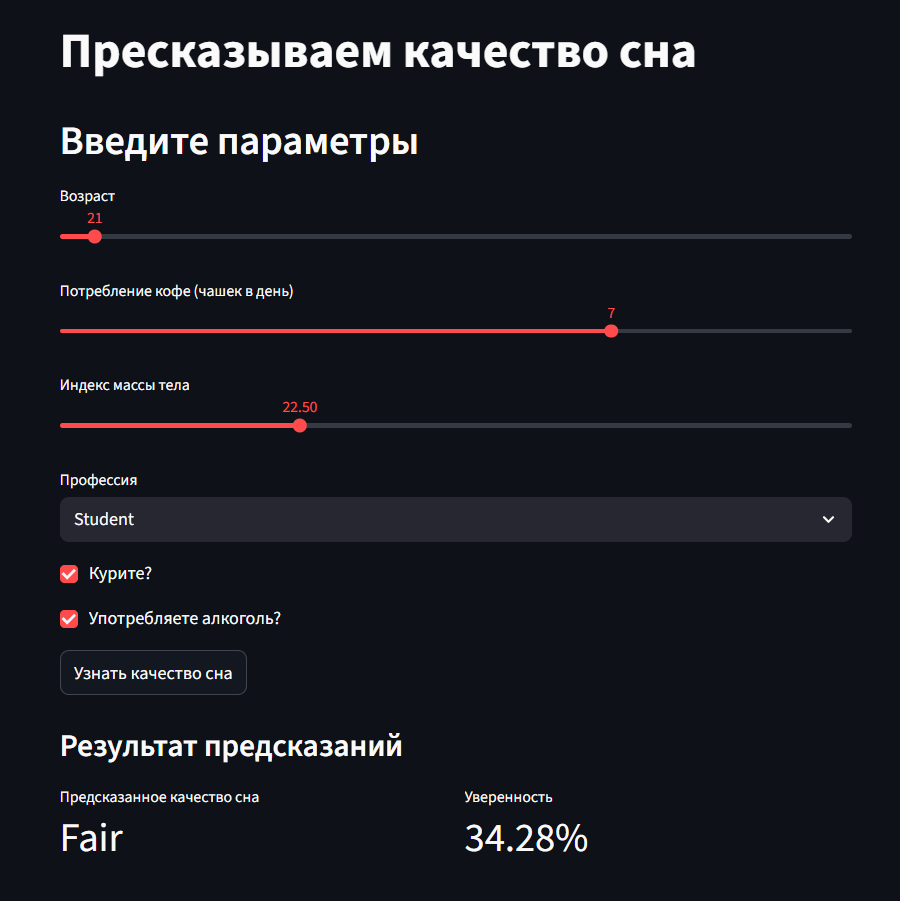

<p class="task" id="5"></p>

5\. Расширьте возможности приложения, добавив возможность отобразить информацию о топ-k наиболее вероятных классов в виде столбчатой диаграммы. Значение k должно выбираться при помощи визуального элемента "слайдер". 

Продемонстрируйте работу, вставив в ячейку скриншоты, подтверждающие корректность решения.

- [ ] Проверено на семинаре


In [115]:
%%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
import pytorch_lightning as pl
import joblib
import json
import numpy as np
import pandas as pd
from pathlib import Path


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        if alpha is not None:
            self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        else:
            self.register_buffer('alpha', None)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction="none")(logits, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        return focal_loss

class SimpleNN(pl.LightningModule):
    def __init__(self, input_dim, num_classes, lr=1e-3, alpha=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, num_classes)
        )
        self.loss_fn = FocalLoss(alpha=alpha, gamma=2.0)
        
    def forward(self, x):
        return self.model(x)

@st.cache_resource
def load_prediction_artifacts(artifacts_dir="artifacts"):
    artifacts_path = Path(artifacts_dir)
    with open(artifacts_path / "metadata.json", 'r') as f:
        metadata = json.load(f)
    checkpoint_path = metadata["pytorch_lightning_checkpoint"]
    model = SimpleNN.load_from_checkpoint(checkpoint_path, map_location=torch.device('cpu'))
    model.eval()
    scaler = joblib.load(metadata["scaler"])
    label_encoders = {}
    for name, path in metadata["label_encoders"].items():
        label_encoders[name] = joblib.load(path)
    print("Артефакты для предсказания успешно загружены.")
    return {
        "model": model,
        "scaler": scaler,
        "label_encoders": label_encoders,
        "metadata": metadata
    }

def predict_quality(age, coffee_intake, bmi, smoking, alcohol_consumption, occupation, artifacts):
    model = artifacts["model"]
    scaler = artifacts["scaler"]
    label_encoders = artifacts["label_encoders"]
    
    num_features = np.array([[age, coffee_intake, bmi]], dtype=np.float32)
    scaled_num_features = scaler.transform(num_features)
    
    smoking_str = '1' if smoking else '0'
    alcohol_str = '1' if alcohol_consumption else '0'
    
    smoking_encoded = label_encoders["Smoking"].transform([smoking_str])[0]
    alcohol_encoded = label_encoders["Alcohol_Consumption"].transform([alcohol_str])[0]
    occupation_encoded = label_encoders["Occupation"].transform([occupation])[0]
    
    cat_features = np.array([[smoking_encoded, alcohol_encoded, occupation_encoded]], dtype=np.float32)
    
    all_features = np.concatenate([scaled_num_features, cat_features], axis=1)
    
    input_tensor = torch.from_numpy(all_features).to(model.device)
    with torch.no_grad():
        logits = model(input_tensor)
    
    probabilities = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    
    le_target = label_encoders["Sleep_Quality"]
    class_names = le_target.classes_
    result_df = pd.DataFrame([probabilities], columns=class_names)
    
    return result_df

st.title('Пресказываем качество сна')

artifacts = load_prediction_artifacts()
le_occupation = artifacts["label_encoders"]["Occupation"]
le_target = artifacts["label_encoders"]["Sleep_Quality"]
num_classes = len(le_target.classes_)

st.header('Введите параметры')

age = st.slider('Возраст', 18, 100, 30)
coffee_intake = st.slider('Потребление кофе (чашек в день)', 0, 10, 2)
bmi = st.slider('Индекс массы тела', 15.0, 40.0, 22.5, 0.1)

occupation = st.selectbox('Профессия', options=le_occupation.classes_)

smoking = st.checkbox('Курите?')
alcohol_consumption = st.checkbox('Употребляете алкоголь?')

st.header('Параметры диаграммы')
top_k = st.slider('Количество топ-к классов для отображения', min_value=1, max_value=num_classes, value=3)


if st.button('Узнать качество сна'):
    probabilities_df = predict_quality(
        age, coffee_intake, bmi, smoking, alcohol_consumption, occupation, artifacts
    )
    
    predicted_class_name = probabilities_df.idxmax(axis=1)[0]
    confidence = probabilities_df.max(axis=1)[0]
    
    st.subheader("Результат предсказаний")
    
    col1, col2 = st.columns(2)
    col1.metric("Предсказанное качество сна", predicted_class_name)
    col2.metric("Уверенность", f"{confidence * 100:.2f}%")
    
    st.subheader(f'Топ {top_k} предсказаний')
    
    top_k_preds = probabilities_df.T.sort_values(by=0, ascending=False).head(top_k)
    top_k_preds.columns = ['Probability']
    top_k_preds.index.name = 'Качество сна'
    
    st.bar_chart(top_k_preds)

Overwriting app.py


In [116]:
stop_streamlit()
start_streamlit()

Останавливаем Streamlit...
Сервер Streamlit остановлен.
Запускаем Streamlit...
Сервер Streamlit запущен. Ожидание URL...

✅ Ваше приложение доступно по ссылке: http://localhost:8504



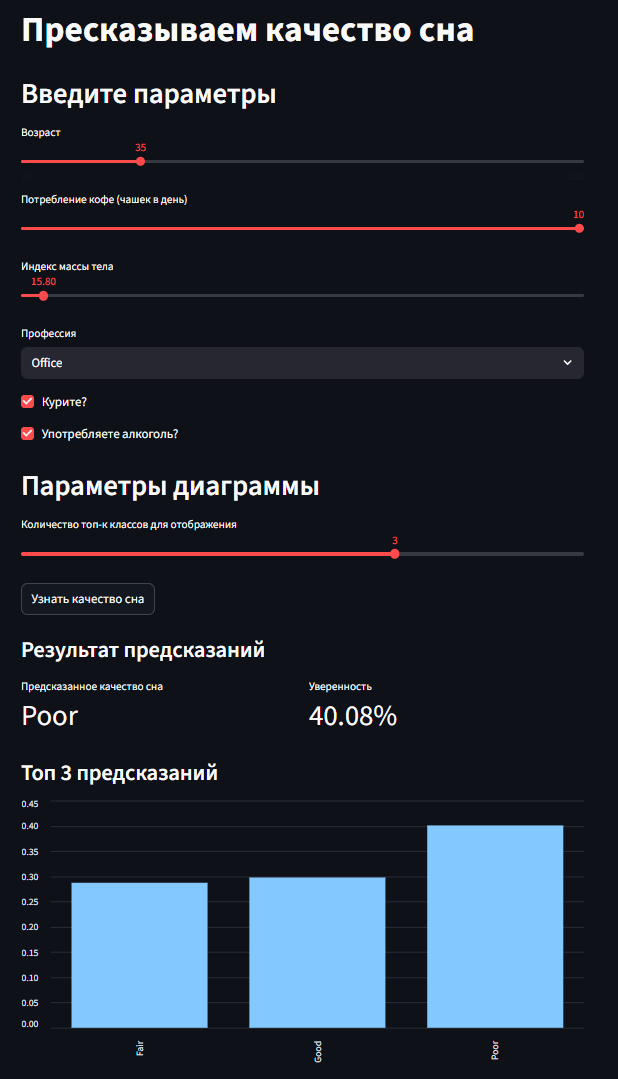